# Demo notebook for APPRAISE

Author: Xiaozhe Ding

Email: xding@caltech.edu, dingxiaozhe@gmail.com

## Introduction

In this demo, we'll use APPRAISE to screen a library made of 100 AAV9-based variants for their binding propensities to LY6A receptor, as described in Fig.3 of *Ding et al.*.

![workflow](./Workflow.png)

Please read the instruction above each executable box and determine which ones you need to execute and the modifications you need to make.

## Stage 0 - Environment and package installation

#### Check the environment

APPRAISE 1.2 was tested with the following environment. We suggest using versions equal or higher than these for optimal compatibility:

For input file preparation and data analysis:

 - MacOS 10.14.6

 - Python 3.6.10

 - PyMOL 2.3.3 (Schrodinger LLC.)

 - Python packages: 

    - numpy 1.18.2

    - pandas 1.1.5

    - matplotlib 3.2.1

    - seaborn 0.11.2

For structural modeling:

- slphafold-colabfold 2.1.14 (Accessed using Google Colaboratory. Notebook available [here](https://github.com/sokrypton/ColabFold))
    - AlphaFold model version: AlphaFold-multimer-v2


#### APPRAISE package

If you haven't install the appraise package, run the following box in the notebook to install the package. ***You'll need to restart the kernal after installation***. 

Skip this block if the package had already been installed.

In [ ]:
!pip install -e ../../appraise

## Stage 1 - Pooled selection

### 1.1 - Prepare input fasta files for pooled competition in AlphaFold

In [ ]:
# Import necessary modules
import appraise
from appraise.utilities import *
from appraise.input_fasta_prep import *

# Make sure the working directory is in the demo folder to avoid issues related to relative paths
import os
demo_path = '/'.join(os.path.abspath(appraise.__file__).split('/')[:-2]) + '/demo/'
os.chdir(demo_path)

The peptide sequences should be provided in a .csv table with two columns titled "peptide_name" and "peptide_seq", respectively.

You can find example peptide listes in folde ./sequences_from_the_manuscript. 

Generate pooled fastas with random grouping 1 (4 variants per group):

In [ ]:
csv_file_path = interactive_input('csv_file_path','./demo_AAV_100_screening/stage_1/AAV_mock_selection_100_peptide_list.csv')

folder_path_for_fastas = interactive_input('folder_path_for_fastas', './demo_AAV_100_screening/stage_1/stage_1_grouping_1_input_fasta/')

receptor_name = interactive_input('receptor_name', 'Ly6a')

receptor_seq = interactive_input('receptor_seq', "LECYQCYGVPFETSCPSITCPYPDGVCVTQEAAVIVDSQTRKVKNNLCLPICPPNIESMEILGTKVNVKTSCCQEDLCNVAVP")

pool_size = interactive_input('pool_size', 4)

peptide_names, peptide_seqs = load_peptides(csv_file_path)

list_query_sequence, list_jobname = get_complex_fastas(receptor_name, \
                                                                        receptor_seq,
                                                                        peptide_names, \
                                                                        peptide_seqs, \
                                                                        mode = 'pooled', \
                                                                        pool_size = pool_size,\
                                                                        folder_path = folder_path_for_fastas)

Generate pooled fastas with random grouping 2 (4 variants per group):

In [ ]:
csv_file_path = interactive_input('csv_file_path','./demo_AAV_100_screening/stage_1/AAV_mock_selection_100_peptide_list.csv')

folder_path_for_fastas = interactive_input('folder_path_for_fastas', './demo_AAV_100_screening/stage_1/stage_1_grouping_2_input_fasta/')

receptor_name = interactive_input('receptor_name', 'Ly6a')

receptor_seq = interactive_input('receptor_seq', "LECYQCYGVPFETSCPSITCPYPDGVCVTQEAAVIVDSQTRKVKNNLCLPICPPNIESMEILGTKVNVKTSCCQEDLCNVAVP")

pool_size = interactive_input('pool_size', 4)

peptide_names, peptide_seqs = load_peptides(csv_file_path)

list_query_sequence, list_jobname = get_complex_fastas(receptor_name, \
                                                                        receptor_seq,
                                                                        peptide_names, \
                                                                        peptide_seqs, \
                                                                        mode = 'pooled', \
                                                                        pool_size = pool_size,\
                                                                        folder_path = folder_path_for_fastas)

### 1.2 - Run structural prediction

The structures can be modeled using AlphaFold2-multimer or other state-of-the-art structure-prediction tools. 

For easy access to AlphaFold2-multimer, we suggest using ColabFold, an integrated implementation of multiple sequence alignment and AlphaFold (Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S and Steinegger M. ColabFold: Making protein folding accessible to all., Nature Methods (2022) doi: 10.1038/s41592-022-01488-1).

To use the ColabFold notebook, you can make a copy of [the ColabFold-batch notebook](https://github.com/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb) to a Google account, upload fasta files to the input folder, and hit "run all" in the Colab notebook.  Suggested settings:

```

msa_mode = MMseqs2 (UniRef+Environmental)

num_models = 5

num_recycles = 3

stop_at_score = 100

use_amber = False

use_templates = True

do_not_overwrite_results = False

zip_results = False

model_type = "auto" #In colabfold 2.1.14, AlphaFold2-multimer-v2 is used by default.

```


Note: 

1. Google encourages interactive usage of Colab and they may limit usage of GPU for long runs. Empirically, we suggest running < 20 fasta files at a time for free users and < 100 fasta files at a time for Colab Pro Plus users.

2. If you wish to use another version of AlphaFold model (e.g., AlphaFold2-multimer-v1) in the Colab batch notebook, you will need to make two modifications manually. First, copy the lines below and paste it to the top of the "Run prediction" block so that the notebook can download the correct parameters. Second, change the "model_type" argument in the line with "run(...)" in the "Run prediction" block to the desired model type.
```
# Force to download for the appropriate model type
model_type = "AlphaFold2-multimer-v1" #See ColabFold documentation for other available model types
from colabfold.download import download_alphafold_params
from pathlib import Path
download_alphafold_params(model_type, Path("/root/.cache/colabfold/"))
```

If your session is terminated in the middle, You can delete the input fasta files for the models that were already finished and restart the session to continue with the rest. Sometimes you may need to wait for hours to regain access to a GPU session.

### 1.3 - Quantify the structure models

The PyMOL script appraise/pymol_quantify_peptide_binding.py will analyze the pdb files in a folder and generate a csv file containing all measurements in parent folder of the pdb results folder. 

*Note: If you did not use ColabFold for the modeling, the file names of the models need to be changed to the following format, where the bracketed part can be any filler string with a total length of 14 characters:*
```
'ReceptorName_and_Peptide1Name_vs_Peptide2Name_vs_..._vs_PeptideNName_unrelaxed_[14Characters].pdb'
```

#### Option 1: Run the quantification script in **pymol prompt**

In PyMOL, use the following lines (the can be adjusted):

```
# Load the script (replace "/path/to/APPRAISE" with the actual path)
run /path/to/APPRAISE/appraise/pymol_quantify_peptide_binding.py

# Call the quantification function (change the parameters as needed)
quantify_binding('path_to_results_folder/', use_relaxed=False, time_stamp=True, mod_start_resi=3, mod_end_resi=9, pLDDT_threshold=0, membrane_anchor_site='C-term')
```

*Note: The script will take a few minutes to run, and the PyMOL GUI might be frozen while the script is running, which is normal.*

#### Option 2: Run the quantification script in **terminal** or **JuPyter notebook**. 

*Note: Currently you can run the script outside PyMOL only with default parameters. If you need to change the parameters for the quantification function, use Option 1 instead.*

The pymol script can also be launched from the terminal (https://www.pymolwiki.org/index.php/Launching_From_a_Script). 

General syntax:

```
pymol -cq /path/to/APPRAISE/appraise/pymol_quantify_peptide_binding.py /path/to/results/folder/
```

You will need to replace "/path/to/APPRAISE" with the actual path. You might also need to change "pymol" to the actual location of the executable, depending on your operation system and PyMOL release.

For example, MacOS users using PyMOL provided by Schrödinger can run the box below within this Jupyter notebook:

In [ ]:
# Make sure the working directory is in the demo folder to avoid issues related to relative paths
import appraise
import os
demo_path = '/'.join(os.path.abspath(appraise.__file__).split('/')[:-2]) + '/demo/'
os.chdir(demo_path)

# Execute the PyMOL script
!/Applications/PyMOL.app/Contents/MacOS/PyMOL -cq ../appraise/pymol_quantify_peptide_binding.py ./demo_AAV_100_screening/stage_1/stage_1_alphafold_modeling_results/

### 1.4 - Analyze the pooled_competition results

In [ ]:
# Import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary APPRAISE modules
import appraise
from appraise.utilities import *
from appraise.score_calculation import *

# Make sure the working directory is in the demo folder to avoid issues related to relative paths
import os
demo_path = '/'.join(os.path.abspath(appraise.__file__).split('/')[:-2]) + '/demo/'

os.chdir(demo_path)

#### Load the measurements

Use the following block to load the .csv file generated by the PyMOL script. 

An example measurements is also available in the demo.

Default Path to database file (*.csv) is [./demo_AAV_100_screening/stage_1/database_APPRAISE_measurements_stage_1_example.csv], need to change? Provide new value or hit Enter to use default


>  


Default Receptor of interest (need to match the name in input fasta file names) is [Ly6a], need to change? Provide new value or hit Enter to use default


>  


Default R_minor of the receptor is [13.4], need to change? Provide new value or hit Enter to use default


>  


Default Version of APPRAISE to use is [1.2], need to change? Provide new value or hit Enter to use default


>  



A database with 100 peptides is successfully loaded! 


Quality check: 
 The following plot shows the number of models for each peptide variant in the database. 
 You should expect to see an equal number of models in all variants. 
 If the numbers are not equal, there might some models missing during structure prediction or quantification. You can still proceed with the risk of getting biased rankings.
 Double click on the plot to Zoom in. 


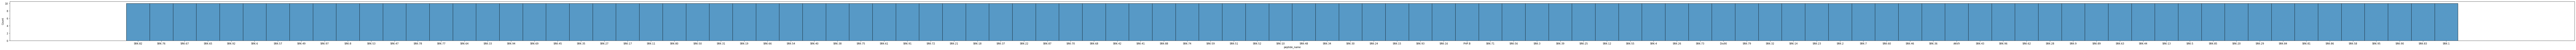

In [2]:
# Get the settings
database_path = interactive_input('Path to database file (*.csv)','./demo_AAV_100_screening/stage_1/database_APPRAISE_measurements_stage_1_example.csv')
receptor_of_interest = interactive_input('Receptor of interest (need to match the name in input fasta file names)', 'Ly6a')
receptor_Rminor = float(interactive_input('R_minor of the receptor', 13.4))
APPRAISE_version = float(interactive_input('Version of APPRAISE to use', 1.2))

# Read and calculate scores
df = pd.read_csv(database_path)
df = df.loc[df['receptor_name'] == receptor_of_interest].copy()
df['receptor_Rminor'] = receptor_Rminor
list_peptide_names, list_peptide_seqs = get_peptide_list_from_model_names(df)

df_sorted = sort_df_by_peptides_and_cleanup(df, list_peptide_names)

print('\nA database with {} peptides is successfully loaded! \n'.format(len(list_peptide_names)))

# Quality check
print('\nQuality check: \n \
The following plot shows the number of models for each peptide variant in the database. \n \
You should expect to see an equal number of models in all variants. \n \
If the numbers are not equal, there might some models missing during structure prediction or quantification. You can still proceed with the risk of getting biased rankings.\n \
Double click on the plot to Zoom in. ')

plt.rcParams["figure.figsize"] = (len(list_peptide_names)*1.5, 3)
sns.histplot(df, x='peptide_name')
plt.tight_layout()

#### Rank by mean aboslute binding score ($\overline{B}_2^{POI}$)

Calculate the individual binding score in each individual competition ($B_2^{POI, competitor}$):

In [3]:
df = calculate_scores(df, version=APPRAISE_version)
df[['peptide_name','B_POI']]

,peptide_name,B_POI
0,SRK-42,0.018572
1,SRK-30,250.565072
2,SRK-73,14.759694
3,Dis90,62.420330
4,SRK-24,137.510546
...,...,...
995,AAV9,-0.000000
996,SRK-77,-0.000000
997,SRK-33,140.388926
998,SRK-64,18.680801


Get the mean binding scores ($\overline{B}_2^{POI}$)

In [4]:
# Sort the peptides
df_average_by_POI = df.groupby(by=['peptide_name','peptide_seq']).mean().dropna(subset=['B_POI']).reset_index()
df_average_by_POI[['peptide_name','B_POI']]

,peptide_name,B_POI
0,SRK-82,60.545884
1,SRK-76,67.773840
2,SRK-67,75.763764
3,SRK-65,20.612449
4,SRK-92,52.214733
...,...,...
95,SRK-58,40.682409
96,SRK-95,26.202746
97,SRK-90,85.831057
98,SRK-83,36.438845


Run the following code block to get a the absolute binding scores of the variants and a list of top peptides that can be used for stage 2.

The results will be saved in the save directory as the database.

In [5]:
# Select the top variants
N_top = int(interactive_input('Number of top variants to keep', 18))
df_average_by_POI = df_average_by_POI.sort_values(by='B_POI', ascending=False).reset_index()
df_selected_peptides = df_average_by_POI.loc[0:N_top, ['peptide_name', 'peptide_seq', 'B_POI']]


#Save the results
print('\nSuccess!')
score_file_path = '/'.join(database_path.split('/')[:-1]) + '/APPRAISE{}_scores_of_all_peptides.csv'.format(str(APPRAISE_version))
df_average_by_POI.to_csv(score_file_path)
print('\nThe APPRAISE scores of peptide variants are saved in {}'.format(score_file_path))
selected_peptide_list_path = '/'.join(database_path.split('/')[:-1]) + '/APPRAISE{}_selected_top_{}_peptides.csv'.format(str(APPRAISE_version), str(N_top))
df_selected_peptides.to_csv(selected_peptide_list_path)
print('\nThe list of selected peptides is saved as {}'.format(selected_peptide_list_path))

# Display the results
print('\nHere is the list of selected peptide variants:\n')
df_selected_peptides

Default Number of top variants to keep is [18], need to change? Provide new value or hit Enter to use default


>  



Success!

The APPRAISE scores of peptide variants are saved in ./demo_AAV_100_screening/stage_1/APPRAISE1.2_scores_of_all_peptides.csv

The list of selected peptides is saved as ./demo_AAV_100_screening/stage_1/APPRAISE1.2_selected_top_18_peptides.csv

Here is the list of selected peptide variants:



,peptide_name,peptide_seq,B_POI
0,SRK-53,AQLTSSNALAQAQTG,173.804960
1,SRK-50,AQNNFNASLAQAQTG,166.991482
2,SRK-28,AQIVSNQMSAQAQTG,122.505731
3,SRK-24,AQFNSKLQLAQAQTG,118.724006
4,SRK-8,AQTHDAQAWAQAQTG,117.117370
5,Dis90,AQWKNMGLQAQAQTG,113.283974
6,SRK-78,AQTAYLEVKAQAQTG,107.396226
7,PHP.B,AQTLAVPFKAQAQTG,105.530522
8,SRK-39,AQLGDITGFAQAQTG,104.153545
9,SRK-64,AQVFQATRTAQAQTG,103.654788


#### Plot the results

The following code block shows an example to create an overview plot of scores of individual models.

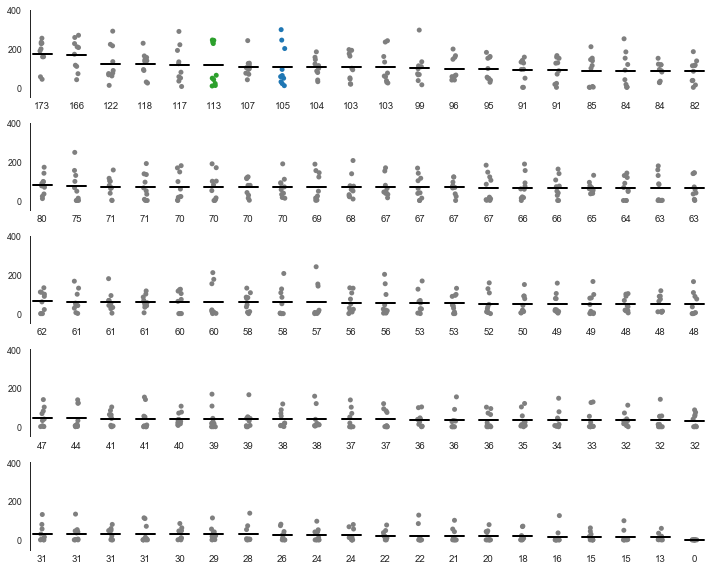

In [6]:
# Set number of subplots
n_rows = 5
n_columns = 20

# Configure the plot
sns.set_style("white")
sns.set_context("paper")

plt.rcParams["figure.figsize"] = (10, 8)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns)

# Plot each peptide in a subplot
for i, peptide_name in enumerate(df_average_by_POI['peptide_name']):
    j = i // n_columns
    k = i % n_columns
    
    # Set the y axis display rules depending on the position
    if k == 0:
        sns.despine(bottom = True, left=False, right=True, ax=axes[j, k])
    else:
        sns.despine(bottom = True, left=True, right=True, ax=axes[j, k])
        axes[j,k].set(yticklabels=[])
 
    # Set coloring -- highlight PHP.B, Dis90, and AAV9
    if peptide_name == 'PHP.B':
        color_setting = sns.color_palette()[0]
    elif peptide_name == 'Dis90':
        color_setting = sns.color_palette()[2]
    elif peptide_name == 'AAV9':
        color_setting = sns.color_palette("tab10")[7]
    else:
        color_setting = sns.color_palette()[7]
    
    # Plot the data points
    sns.stripplot(ax=axes[j,k], y="B_POI", data=df.loc[df['peptide_name']==peptide_name], color=color_setting)
    
    # Plot the mean bar
    sns.boxplot(ax=axes[j,k], 
            showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            y="B_POI",
            data=df.loc[df['peptide_name']==peptide_name],
            showfliers=False,
            showbox=False,
            showcaps=False)
    
    # Annotate the reads
    axes[j, k].annotate(int(np.mean(df.loc[df['peptide_name']==peptide_name, "B_POI"])), xy=(0.5, -0.1), xycoords='axes fraction', ha='center', va='center')
    #axes[j, k].set_title(variable_name, wrap=True)
    axes[j,k].set_ylim(-50, 400)
    axes[j,k].set_xlabel('')
    axes[j,k].set_ylabel('')
    axes[j,k].set(xticklabels=[])
   
    
plt.tight_layout()
fig.savefig('/'.join(database_path.split('/')[:-1]) + '/stage_1_results.png', dpi=300)


## Stage 2 - Pair-wise competition for accurate ranking of top variants

### 2.1 - Prepare input fasta files for pooled competition in AlphaFold

In [1]:
# Import necessary modules
import appraise
from appraise.utilities import *
from appraise.input_fasta_prep import *

# Make sure the working directory is in the demo folder to avoid issues related to relative paths
import os
demo_path = '/'.join(os.path.abspath(appraise.__file__).split('/')[:-2]) + '/demo/'
os.chdir(demo_path)


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


The peptide sequences should be provided in a .csv table with two columns titled "peptide_name" and "peptide_seq", respectively.

You can find example peptide listes in folde ./sequences_from_the_manuscript. 

Generate pooled fastas with random grouping 1 (4 variants per group):

#### Generate input fasta for pairwise matrix

In [ ]:
# Check if the variable is still in memory
if 'selected_peptide_list_path' in globals():
    csv_file_path_default = selected_peptide_list_path
else:
    csv_file_path_default = './demo_AAV_100_screening/stage_1/APPRAISE1.2_selected_top_18_peptides.csv'

csv_file_path = interactive_input('csv_file_path',csv_file_path_default) #@param {type:"string"}

folder_path_for_fastas = interactive_input('folder_path_for_fastas', './demo_AAV_100_screening/stage_2/stage2_input_fasta/')#@param {type:"string"}

receptor_name = interactive_input('receptor_name', 'Ly6a') #@param {type:"string"}

receptor_seq = interactive_input('receptor_seq', "LECYQCYGVPFETSCPSITCPYPDGVCVTQEAAVIVDSQTRKVKNNLCLPICPPNIESMEILGTKVNVKTSCCQEDLCNVAVP") #@param {type:"string"}

peptide_names, peptide_seqs = load_peptides(csv_file_path)

list_query_sequence, list_jobname = get_complex_fastas(receptor_name, \
                                                        receptor_seq, \
                                                        peptide_names, \
                                                        peptide_seqs, \
                                                        mode = 'pairwise', \
                                                        square_matrix = True, \
                                                        folder_path = folder_path_for_fastas)

### 2.2 - Run structural prediction

The structures can be modeled using AlphaFold2-multimer or other state-of-the-art structure-prediction tools. 

For easy access to AlphaFold2-multimer, we suggest using ColabFold, an integrated implementation of multiple sequence alignment and AlphaFold (Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S and Steinegger M. ColabFold: Making protein folding accessible to all., Nature Methods (2022) doi: 10.1038/s41592-022-01488-1).

To use the ColabFold notebook, you can make a copy of [the ColabFold-batch notebook](https://github.com/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb) to a Google account, upload fasta files to the input folder, and hit "run all" in the Colab notebook.  Suggested settings:

```

msa_mode = MMseqs2 (UniRef+Environmental)

num_models = 5

num_recycles = 3

stop_at_score = 100

use_amber = False

use_templates = True

do_not_overwrite_results = False

zip_results = False
```


Note: Google encourages interactive usage of Colab and they may limit usage of GPU for long runs. Empirically, we suggest running < 20 fasta files at a time for free users and < 100 fasta files at a time for Colab Pro Plus users.

If your session is terminated in the middle, You can delete the input fasta files for the models that were already finished and restart the session to continue with the rest. Sometimes you may need to wait for hours to regain access to a GPU session.

### 2.3 - Quantify the structure models

The PyMOL script appraise/pymol_quantify_peptide_binding.py will analyze the pdb files in a folder and generate a csv file containing all measurements in parent folder of the pdb results folder. 

*Note: If you did not use ColabFold for the modeling, the file names of the models need to be changed to the following format, where the bracketed part can be any filler string with a total length of 14 characters:*
```
'ReceptorName_and_Peptide1Name_vs_Peptide2Name_vs_..._vs_PeptideNName_unrelaxed_[14Characters].pdb'
```

#### Option 1: Run the quantification script in **pymol prompt**

In PyMOL, use the following lines (the can be adjusted):

```
# Load the script (replace "/path/to/APPRAISE" with the actual path)
run /path/to/APPRAISE/appraise/pymol_quantify_peptide_binding.py

# Call the quantification function (change the parameters as needed)
quantify_binding('path_to_results_folder/', use_relaxed=False, time_stamp=True, mod_start_resi=3, mod_end_resi=9, pLDDT_threshold=0, membrane_anchor_site='C-term')
```

*Note: The script will take a few minutes to run, and the PyMOL GUI might be frozen while the script is running, which is normal.*

#### Option 2: Run the quantification script in **terminal** or **JuPyter notebook**. 

*Note: Currently you can only run the script outside PyMOL with default parameters. If you need to change the parameters for the quantification function, use Option 1 instead.*

The pymol script can also be launched from the terminal (https://www.pymolwiki.org/index.php/Launching_From_a_Script). 

General syntax:


```
pymol -cq /path/to/APPRAISE/appraise/pymol_quantify_peptide_binding.py /path/to/results/folder/
```

You will need to replace "/path/to/APPRAISE/" with the actual path. You might also need to change "pymol" to the actual location of the executable, depending on your operation system and PyMOL release.

For example, MacOS users using PyMOL provided by Schrödinger can run the box below. (The modeling results need to be stored in ./demo_AAV_100_screening/stage_2/stage_2_alphafold_modeling_results/) 

In [ ]:
# Make sure the working directory is in the demo folder to avoid issues related to relative paths
import appraise
import os
demo_path = '/'.join(os.path.abspath(appraise.__file__).split('/')[:-2]) + '/demo/'
os.chdir(demo_path)

# Execute the PyMOL script in terminal
!/Applications/PyMOL.app/Contents/MacOS/PyMOL -cq ../appraise/pymol_quantify_peptide_binding.py ./demo_AAV_100_screening/stage_2/stage_2_alphafold_modeling_results/

### 2.4 - Analyze the pair-wise-competition results

In [1]:
# Import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary APPRAISE modules
import appraise
from appraise.utilities import *
from appraise.score_calculation import *

# Make sure the working directory is in the demo folder to avoid issues related to relative paths
import os
demo_path = '/'.join(os.path.abspath(appraise.__file__).split('/')[:-2]) + '/demo/'
os.chdir(demo_path)


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


#### Load the measurements

Use the following block to load the .csv file generated by the PyMOL script. 

An example measurements is also available in the demo.

Default Path to database file (*.csv) is [./demo_AAV_100_screening/stage_2/database_APPRAISE_measurements_stage_2_example.csv], need to change? Provide new value or hit Enter to use default


>  


Default Receptor of interest (need to match the name in input fasta file names) is [Ly6a], need to change? Provide new value or hit Enter to use default


>  


Default R_minor of the receptor is [13.4], need to change? Provide new value or hit Enter to use default


>  


Default Version of APPRAISE to use is [1.2], need to change? Provide new value or hit Enter to use default


>  



A database with 18 peptides is successfully loaded! 


Quality check: 
 The following plot shows the number of models for each peptide variant in the database. 
 You should expect to see an equal number of models in all variants. 
 If the numbers are not equal, there might some models missing during structure prediction or quantification. You can still proceed with the risk of getting biased rankings.
 Double click on the plot to Zoom in. 


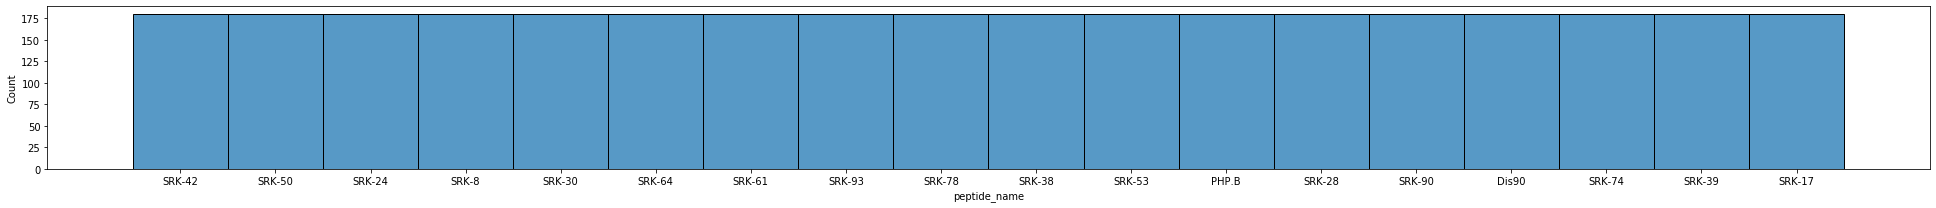

In [2]:
# Get the settings
database_path = interactive_input('Path to database file (*.csv)','./demo_AAV_100_screening/stage_2/database_APPRAISE_measurements_stage_2_example.csv')
receptor_of_interest = interactive_input('Receptor of interest (need to match the name in input fasta file names)', 'Ly6a')
receptor_Rminor = float(interactive_input('R_minor of the receptor', 13.4))
APPRAISE_version = float(interactive_input('Version of APPRAISE to use', 1.2))

# Read and calculate scores
df = pd.read_csv(database_path)
df = df.loc[df['receptor_name'] == receptor_of_interest].copy()
df['receptor_Rminor'] = receptor_Rminor
list_peptide_names, list_peptide_seqs = get_peptide_list_from_model_names(df)
print('\nA database with {} peptides is successfully loaded! \n'.format(len(list_peptide_names)))

# Quality check
print('\nQuality check: \n \
The following plot shows the number of models for each peptide variant in the database. \n \
You should expect to see an equal number of models in all variants. \n \
If the numbers are not equal, there might some models missing during structure prediction or quantification. You can still proceed with the risk of getting biased rankings.\n \
Double click on the plot to Zoom in. ')

plt.rcParams["figure.figsize"] = (len(list_peptide_names)*1.5, 3)
sns.histplot(df, x='peptide_name')
plt.tight_layout()

#### Rank by average relative binding score ($\overline{\Delta B}_2^{POI, competitor}$)

Calculate the individual binding score in each individual competition ($\Delta B_2^{POI, competitor}$):

In [3]:
# Get a dataframe that is sorted pair-wise
df_pairwise_sorted = sort_df_by_peptides_and_cleanup(df, list_peptide_names)

# Calculate the pair-wise scores
df_pairwise_sorted = calculate_scores(df_pairwise_sorted, version=APPRAISE_version, depth_constraint=True)
df_pairwise_sorted[['peptide_name','competitor','Delta_B']]

,peptide_name,competitor,Delta_B
108,SRK-90,SRK-90,82.845787
109,SRK-90,SRK-90,-82.845787
388,SRK-90,SRK-90,45.742816
389,SRK-90,SRK-90,-16.742816
988,SRK-90,SRK-90,38.155300
...,...,...,...
2407,SRK-24,SRK-24,2.369948
2512,SRK-24,SRK-24,132.227458
2513,SRK-24,SRK-24,-132.227458
2844,SRK-24,SRK-24,115.189250


Get the mean binding scores ($\overline{\Delta B}_2^{POI, competitor}$)

In [4]:
# Sort the peptides
df_pairwise_average = df_pairwise_sorted.groupby(by=['peptide_name','competitor','peptide_seq']).mean().dropna(subset=['Delta_B']).reset_index()
df_pairwise_average[['peptide_name','competitor','Delta_B']]

,peptide_name,competitor,Delta_B
0,SRK-90,SRK-90,8.299999
1,SRK-90,SRK-61,-68.921358
2,SRK-90,SRK-42,-121.683161
3,SRK-90,SRK-30,-50.446398
4,SRK-90,SRK-74,-77.808182
...,...,...,...
319,SRK-24,SRK-93,141.462481
320,SRK-24,SRK-64,5.867203
321,SRK-24,SRK-38,-58.892360
322,SRK-24,SRK-53,-45.130607


Run the following code block to get a the absolute binding scores of the variants and a list of top peptides that can be used for stage 2.

The results will be saved in the save directory as the database.

Used p-value threshold of 0.100
Tie threshold to be 1.83 of standard deviation: 46.90


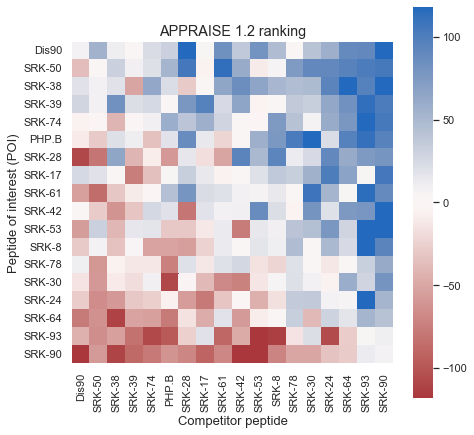

In [5]:
list_peptide_order, _ = plot_heatmap(df_pairwise_average, feature_of_interest='Delta_B', title='APPRAISE 1.2 ranking', rank_by_tournament=True, p_value_threshold=0.1, save_figure=False)
heatmap_figure_path = '/'.join(database_path.split('/')[:-1]) + '/{}_ranked_by_{}.png'.format(receptor_of_interest, 'Delta_B')
plt.savefig(heatmap_figure_path, bbox_inches = 'tight', dpi=300)

In [15]:
print('APPRAISE analysis finished!')
print('The final ranking is: {}'.format(list_peptide_order))
print('The heatmap is saved as {}'.format(heatmap_figure_path))

APPRAISE analysis finished!
The final ranking is: ['Dis90', 'SRK-39', 'SRK-38', 'SRK-50', 'SRK-74', 'PHP.B', 'SRK-17', 'SRK-42', 'SRK-61', 'SRK-53', 'SRK-28', 'SRK-8', 'SRK-78', 'SRK-30', 'SRK-64', 'SRK-24', 'SRK-93', 'SRK-90']
The heatmap is saved as ./demo_AAV_100_screening/stage_2/Ly6a_ranked_by_Delta_B.png
